In [1]:
import os
import pandas as pd
import seaborn as sns
import string
import re
from collections import defaultdict
from helper_functions import group_sort, unique_values, freq_stats_corpora


sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Mission
Développer un système de suggestion de tag pour le site stackoverflow

# Load Data

In [2]:
cur_dir = os.path.dirname(os.getcwd())
num_db = 1
df = pd.DataFrame([])

for i in range(num_db):
    df = df.append(
        pd.read_csv(
            cur_dir + "/db/QueryResults%d.csv" % (i + 1), index_col=0))

In [3]:
df.shape

(50000, 21)

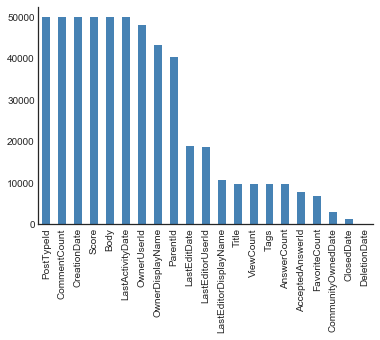

In [4]:
df_count = df.count().sort_values(ascending=False)
fig, ax = plt.subplots()
df_count.plot.bar(color="steelblue", ax=ax)
sns.despine()

__Observation__:
- Each post has an id, PostTypeId, CommentCount, CreationDate, Score and LastActivityDate
- User information are given by OwnerUserId and OwnerDisplayName, almost all posts are given by distinct user.
- Tags have a significant missing values -> users do not tag much

Here, we are interested in analysing the title and body and then suggest tags to users.

In the *unsupervised learning*, tags are not necessary, but in *supervised learning*, tags are the target variable.

In [5]:
# Combine columns
# add an empty space for distinction
df_text = pd.DataFrame(list(zip(df.Title,
                                df.Body)), index = df.index).rename(columns={
                                    0: 'TITLE',
                                    1: 'BODY'
                                })

In [6]:
def stringbetweencode(data):
    p = re.compile("<code>(.+?)<\/code>", flags=re.DOTALL)
    return p.findall(data) 

#df_text["CODE"] = np.nan
df_text["CODE"] = df_text["BODY"].apply(stringbetweencode) 

# EDA for Tags

In [7]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

def tagbetweenbrackets(data):
    p = re.compile(r'<(.*?)>')
    return p.findall(data)

# extract only data with tags
df_tags = df[df.Tags.notnull()].Tags

# extact tags between <>
df_stags = df_tags.apply(tagbetweenbrackets)

# combine all tokens together for freq dist
tagslist = df_stags.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq = FreqDist(tagslist)

In [8]:
from operator import itemgetter
# sort by values in descending order
sorted_tagsfreq = sorted(tagsfreq.items(), key=itemgetter(1), reverse=True)

# prepare for sns.barplot
tags_key, tags_value = zip(*sorted_tagsfreq)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


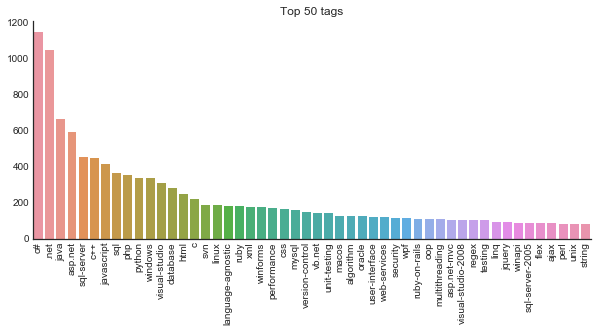

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(tags_key[:n_element]), np.array(tags_value[:n_element]), ax=ax)
ax.set_xticklabels(tags_key[:n_element], rotation=90)
ax.set_title('Top 50 tags')
sns.despine()

# Text preprocessing with scikit learn and NLTK

In [37]:
from sklearn.decomposition import LatentDirichletAllocation
from nltk import regexp_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pdb
wnl = WordNetLemmatizer()


def convert_tag(tag):
    """
    Convert the tag given by nltk.pos_tag 
    to the tag used by wordnet.synsets
    """

    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        # defalut value
        return None


def lemmatizer(doc):
    """
    returns lemmatized tokens after removing stop words and pos tagging
    
    Parameters:
    -----------
    doc: pandas dataframe
        text description in df
    
    Return:
    -------
    pandas dataframe
        lemmatized, pos_tagged, and removed stopwords tokens
    """
    # add words to stoplist, previously punctuations have been removed,
    # so we should do the same for the stoplist
    stoplist = [striphtmlpunct(x) for x in stopwords.words('english')] + ['im']
    #stoplist = stopwords.words('english') + [
    #    "i've", "either", "i'm", "i'd", "would", "could", 'it', "like",
    #    "something", "also", "might", "want", 'this', 'make', 'sure'
    #]
    #return pd.Series(' '.join(
    #    [wnl.lemmatize(word) for word in regexp_tokenize(doc, pattern='\w+|\$[\d\.]+|\S+') if word not in stoplist]))
    lemmatized = []
   
    regex_tokens = regexp_tokenize(doc, pattern='\w+\S+|\.\w+')
    
    for word, p_tags in pos_tag(regex_tokens):
        if word not in set(stoplist):
            convert_pos_tag = convert_tag(p_tags)
            
            # retain nouns only
            if convert_pos_tag == 'n':
                lemmatized.append(wnl.lemmatize(word, pos=convert_pos_tag))
    return lemmatized


def striphtmlpunct(data):
    # remove html tags, code unnecessary punctuations
    p = re.compile(r'<.*?>|[^\w\s+\.\-\#\+]')
    return p.sub('', data)


def striptabs(data):
    # remove tabs breaklines
    p = re.compile(r'(\r\n)+|\r+|\n+|\t+/i')
    return p.sub(' ', data)


# remove html tags
df_text["BODY_STRIPPED"] = df_text.BODY.str.lower().apply(
    striphtmlpunct).apply(striptabs)
df_text["CODE_STRIPPED"] = df_text.CODE.apply(
    lambda x: [striptabs(line.lower()) for line in x if x])
df_text["TITLE_STRIPPED"] = df_text.TITLE.apply(
    lambda x: striphtmlpunct(x.lower()) if (isinstance(x, str)) else x)

# remove stop words, pos_tag, and lemmatize
df_text["BODY_LEMMATIZED"] = df_text["BODY_STRIPPED"].apply(lemmatizer)
df_text["TITLE_LEMMATIZED"] = df_text["TITLE_STRIPPED"].apply(
    lambda x: lemmatizer(x) if (isinstance(x, str)) else x)

## Bag-of-words distribution associated to a tag

### On text title

In [38]:
df_tags_title = pd.DataFrame(
    list(zip(df_stags,
             df_text.loc[df_stags.index,"TITLE_LEMMATIZED"]))).rename(columns={
                 0: "elkey",
                 1: "elvalue"
             })

In [39]:
corpfreq_title, corpstats_title, corpora_title = freq_stats_corpora(
    df_tags_title)

In [40]:
# sort by values in descending order
sorted_corpfreq_title = defaultdict(list)
cutoff = 10

for tag, tagfreq in corpfreq_title.items():
    # only add into sorted_corpfreq if the word occurencces are>50
    if sum(list(tagfreq.values())) > cutoff:
        sorted_corpfreq_title[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


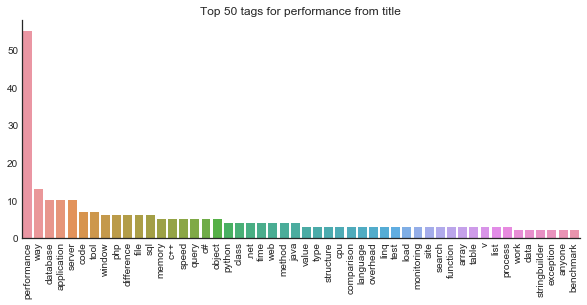

In [53]:
token_index = 3
key = 'performance'#list(sorted_corpfreq_title.keys())[token_index]
corptags_key_title, corptags_value_title = zip(*sorted_corpfreq_title[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_title[:n_element]),
    np.array(corptags_value_title[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_title[:n_element], rotation=90)
ax.set_title('Top 50 tags for %s from title' %key)
sns.despine()

### On text body

In [42]:
df_tags_body = pd.DataFrame(
    list(zip(df_stags,
             df_text.loc[df_stags.index,"BODY_LEMMATIZED"]))).rename(columns={
                 0: "elkey",
                 1: "elvalue"
             })

In [43]:
corpfreq_body, corpstats_body, corpora_body = freq_stats_corpora(df_tags_body)

In [44]:
# sort by values in descending order
sorted_corpfreq_body = defaultdict(list)
cutoff = 50

for tag, tagfreq in corpfreq_body.items():
    # only add into sorted_corpfreq if the word occurencces are>50
    if sum(list(tagfreq.values())) > cutoff:
        sorted_corpfreq_body[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)

python


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


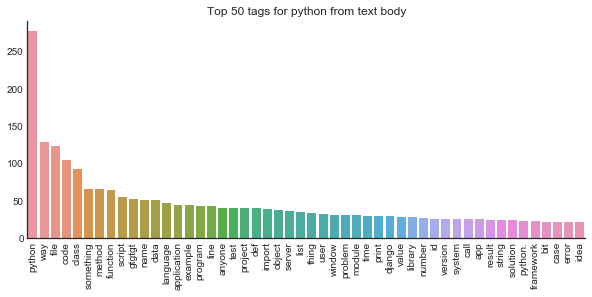

In [54]:
token_index = 3
key = 'python'#list(sorted_corpfreq_body.keys())[token_index]
print(key)
corptags_key_body, corptags_value_body = zip(*sorted_corpfreq_body[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_body[:n_element]),
    np.array(corptags_value_body[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_body[:n_element], rotation=90)
ax.set_title(
    'Top 50 tags for %s from text body' %key)
sns.despine()

In [36]:
import nltk


def convert_tag(tag):
    """
    Convert the tag given by nltk.pos_tag 
    to the tag used by wordnet.synsets
    """

    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        # defalut value
        return None

sentence = ["I","would", "be", "going", "to", "code","in", "c++", "promptly"]
pos_tag = nltk.pos_tag(sentence)
convert_pos_tag = [(i[0], convert_tag(i[1])) for i in pos_tag]
#new_pos_sentence = get_wordnet_pos(pos_sentence)
#[wnl.lemmatize(i[0], pos=i[1]) for i in convert_pos_tag]
print(convert_pos_tag)
print(pos_tag)

[('I', None), ('would', None), ('be', 'v'), ('going', 'v'), ('to', None), ('code', 'v'), ('in', None), ('c++', 'n'), ('promptly', 'r')]
[('I', 'PRP'), ('would', 'MD'), ('be', 'VB'), ('going', 'VBG'), ('to', 'TO'), ('code', 'VB'), ('in', 'IN'), ('c++', 'NN'), ('promptly', 'RB')]


# Count and TFIDF Vectorization with ScikitLearn
## Unigram vs Bigram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_ngram1 = CountVectorizer(ngram_range=(1,1))
tf_ngram1 = vectorizer_ngram1.fit_transform(df_ready[0])

In [ ]:
vectorizer_ngram2 = CountVectorizer(ngram_range=(2,2))
tf_ngram2 = vectorizer_ngram2.fit_transform(df_ready[0])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer_ngram1 = TfidfVectorizer(ngram_range=(1,1))
tfidf_ngram1 = tfidfvectorizer_ngram1.fit_transform(df_ready[0])

In [ ]:
tfidfvectorizer_ngram2 = TfidfVectorizer(ngram_range=(2,2))
tfidf_ngram2 = tfidfvectorizer_ngram2.fit_transform(df_ready[0])

In [ ]:
features_ngram1 = vectorizer_ngram1.get_feature_names()
features_ngram2 = vectorizer_ngram2.get_feature_names()
tfidf_features_ngram1 = tfidfvectorizer_ngram1.get_feature_names()
tfidf_features_ngram2 = tfidfvectorizer_ngram2.get_feature_names()

count_vec_ngram1 = np.asarray(tf_ngram1.sum(axis=0)).ravel()
count_vec_ngram2 = np.asarray(tf_ngram2.sum(axis=0)).ravel()
tfidf_count_vec_ngram1 = np.asarray(tfidf_ngram1.sum(axis=0)).ravel()
tfidf_count_vec_ngram2 = np.asarray(tfidf_ngram2.sum(axis=0)).ravel()

zipped_ngram1 = list(zip(features_ngram1, count_vec_ngram1))
zipped_ngram2 = list(zip(features_ngram2, count_vec_ngram2))
tfidf_zipped_ngram1 = list(zip(tfidf_features_ngram1, tfidf_count_vec_ngram1))
tfidf_zipped_ngram2 = list(zip(tfidf_features_ngram2, tfidf_count_vec_ngram2))

x = [[] for i in range(4)]
y = [[] for i in range(4)]

x[0], y[0] = (
    list(x)
    for x in zip(*sorted(zipped_ngram1, key=lambda x: x[1], reverse=True)))
x[1], y[1] = (
    list(x)
    for x in zip(*sorted(zipped_ngram2, key=lambda x: x[1], reverse=True)))
x[2], y[2] = (list(x) for x in zip(
    *sorted(tfidf_zipped_ngram1, key=lambda x: x[1], reverse=True)))
x[3], y[3] = (list(x) for x in zip(
    *sorted(tfidf_zipped_ngram2, key=lambda x: x[1], reverse=True)))

# Now I want to extract out on the top 15 and bottom 15 words
#Yy = np.concatenate([y[0:15], y[-16:-1]])
#Xx = np.concatenate([x[0:15], x[-16:-1]])

In [ ]:
# Plot 15 top words + 15 bottom words
fig, axes = plt.subplots(2, 2, figsize=(12,8))
num_words = 30

title = ["count unigram", "count bigram", "tfidf unigram", "tfidf bigram"]

for i, ax in enumerate(axes.flatten()):
    sns.barplot(np.array(x[i][:num_words]), np.array(y[i][:num_words]), ax=ax)
    ax.set_xticklabels(x[i][:num_words], rotation=90)
    ax.set_xlabetal("Feature words")
    ax.set_ylabel("Occurences")
    ax.set_title(title[i])
sns.despine()
plt.tight_layout()

__Observation__:
- Bigram or perhaps trigram is better than exploring unigram
- no difference in Count and TFIDF vectorizers for now